In [1]:
import numpy as np
import os
import mne
import pickle
import pandas as pd
from mat73 import loadmat
import matplotlib.pyplot as plt
import osl
import yaml

In [6]:
path = '/gpfs2/well/woolrich/projects/disp_csaky/eeg/session2/preproc1_40hz/cond0/trial0.npy'
data = np.load(path)

In [8]:
len([36,31,5,167,174,28,63,177,33,19,30,140,47,45,166,130,121,168,145,131,132,200,275,176,304,272,17,279,133,149,281,165,181,46,120,15,172,249,198,32,37,6,35,151,303,147,34,27,182,150,173,38,179,129,270,274,250,199,178,170,171,16,29,280,152,141,143,305,251,146,144,65,148,7,24,175,169,273,134,271,25,138,64,26,18,3,142,122,139,4,8,180,20])

93

In [3]:
raw.info

<Info | 25 non-empty values
 acq_pars: ACQactiveGround 1 ACQch.BIO001.gain 2000 ACQch.BIO001.highpass ...
 bads: 1 items (MEG0313)
 ch_names: EOG001, EOG002, ECG003, EMG004, IASX+, IASX-, IASY+, IASY-, ...
 chs: 2 EOG, 1 ECG, 1 EMG, 11 IAS, 102 Magnetometers, 204 Gradiometers, 6 misc, 1 Stimulus, 1 SYST, 9 CHPI
 custom_ref_applied: False
 description: TRIUX system at OHBA-3143 OSL BATCH PROCESSING APPLIED ON ...
 dev_head_t: MEG device -> head transform
 dig: 266 items (3 Cardinal, 5 HPI, 258 Extra)
 events: 1 item (list)
 experimenter: csaky (csaky)
 file_id: 4 items (dict)
 gantry_angle: 68.0
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 2 items (dict)
 line_freq: 50.0
 lowpass: 45.0 Hz
 meas_date: 2022-06-27 14:33:25 UTC
 meas_id: 4 items (dict)
 nchan: 338
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: disp_mmxxi_cviii
 projs: []
 sfreq: 1000.0 Hz
 subject_info: 4 items (dict)
>

In [5]:
raw = loadmat('../data/opm_rich/Task/raw.mat')

In [6]:
raw = raw['data']

In [7]:
drop_inds = [78, 79, 80, 30, 31, 32, 48, 49, 50, 63, 64, 65, 12, 13, 14, 3, 4, 5, 0, 1, 2, 6, 7, 8, 105, 106, 107]
good_inds = [i for i in range(186) if i not in drop_inds]

ch_names = [str(i) for i in good_inds]

In [8]:
raw = raw[good_inds, :]

In [9]:
data = raw

In [10]:
raw.shape

(159, 2320680)

In [12]:
# channel locations
channels = pd.read_csv('../data/opm_rich/Task/20220908_115229_channels.tsv', sep='\t')

In [13]:
chn_dict = []
for i in range(len(channels)):
    if i in good_inds:
        chn_positions = np.array([channels['Px'][i], channels['Py'][i], channels['Pz'][i], 0, 0, 0, 0, 0, 0, 0, 0, 0])

        chd = {'loc': chn_positions, 'ch_name': channels['name'][i], 'kind': 'FIFFV_EEG_CH'}
        chn_dict.append(chd)

In [14]:
ch_names = [d['ch_name'] for d in chn_dict]
info = mne.create_info(ch_names=ch_names, sfreq=1200, ch_types='eeg')

In [15]:
for i in range(len(chn_dict)):
    info['chs'][i]['loc'] = chn_dict[i]['loc']

In [16]:
raw = mne.io.RawArray(data, info)

In [211]:
raw = raw.filter(l_freq=1, h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3961 samples (3.301 sec)



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

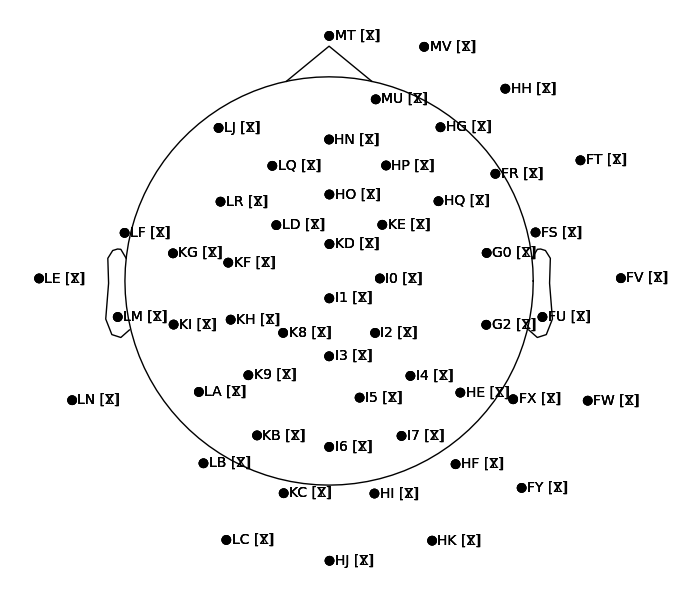

In [212]:
raw.plot_sensors(show_names=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Effective window size : 1.707 (s)


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_27766/1236512385.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.plot_psd(fmax=45)


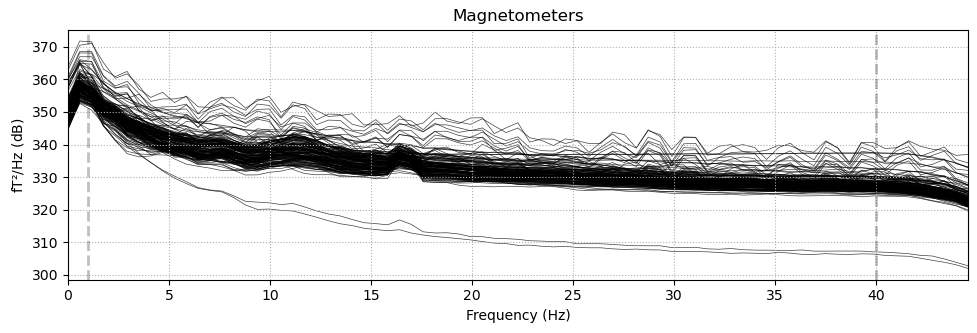

In [41]:
%matplotlib widget
raw.plot_psd(fmax=45)

In [68]:
# reading trials
events = pd.read_csv('rich_data/opm_rich/Task/20220908_115229_events.tsv', sep='\t')

event_c = np.array([events['value'][i] for i in range(len(events))])
event_t = np.array([events['sample'][i] for i in range(len(events))])

new_events = []
for ind, (et, ec) in enumerate(zip(event_t[1:-1], event_c[1:-1])):
    i = ind + 1
    if ec < 7 and ec > 1 and (event_t[i+1] - et) > 5 and (et - event_t[i-1]) > 5:
        new_events.append(np.array([et, 0, ec]))

In [213]:
events = pd.read_csv('rich_data/opm_rich/Task/20220908_115229_events.tsv', sep='\t')

event_c = np.array([events['value'][i] for i in range(len(events))])
event_t = np.array([events['sample'][i] for i in range(len(events))])

count1 = 0
count2 = 0
new_events = []
for ind, (et, ec) in enumerate(zip(event_t[1:-1], event_c[1:-1])):
    think_trial = False
    i = ind + 1
    if ec < 7 and ec > 1 and (event_t[i+1] - et) > 5 and (et - event_t[i-1]) > 5:
        count1 += 1
        if event_c[i+2] == 8:
            new_events.append(np.array([event_t[i+2], 0, ec]))
        else:
            print('error1')
        if event_c[i+3] == 8:
            new_events.append(np.array([event_t[i+3], 0, ec]))
        else:
            print('error2')
        if event_c[i+4] == 8:
            new_events.append(np.array([event_t[i+4], 0, ec]))
        else:
            print('error3')
        if event_c[i+5] == 8:
            new_events.append(np.array([event_t[i+5], 0, ec]))
        else:
            print('error4')

    elif (event_t[i+1] - et) < 5 and ec > 1:
        ec += event_c[i+1]
        think_trial = True

    if think_trial:
        count2 += 1
        split_events = event_c[i-18:i-4]
        #print(split_events)
        tind = np.nonzero(split_events == 7)[0][-1]

        tind += i-18

        if event_c[tind+2] == 8:
            new_events.append(np.array([event_t[tind+2], 0, ec-9]))
        else:
            print('erorr5')
            print(event_c[i-20:i])
        if event_c[tind+3] == 8:
            new_events.append(np.array([event_t[tind+3], 0, ec-9]))
        else:
            print('erorr6')
            print(event_c[i-20:i])
        if event_c[tind+4] == 8:
            new_events.append(np.array([event_t[tind+4], 0, ec-9]))
        else:
            print('erorr7')
        if event_c[tind+5] == 8:
            new_events.append(np.array([event_t[tind+5], 0, ec-9]))
        else:
            print('erorr8')

print(count1)
print(count2)

new_events = np.array(new_events)

141
104


In [70]:
event_dict = {'words/hungry': 2,
              'words/tired': 3,
              'words/thirsty': 4,
              'words/toilet': 5,
              'words/pain': 6}

In [226]:
reject = dict(eeg=2e4)
epochs = mne.Epochs(
                raw,
                new_events,
                tmin=-0.1,
                tmax=1.0,
                baseline=(None, 0),
                preload=True,
                reject=reject
            )

Not setting metadata
980 matching events found
Setting baseline interval to [-0.1, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 980 events and 1321 original time points ...
    Rejecting  epoch based on EEG : ['KH [Z]']


/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_27766/378727091.py:2: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(


    Rejecting  epoch based on EEG : ['K8 [X]', 'K8 [Z]', 'KB [X]', 'KB [Y]', 'KB [Z]', 'KC [Z]', 'LC [Z]', 'I5 [Y]', 'I1 [Y]', 'I3 [Y]', 'I3 [Z]', 'I6 [Y]', 'HJ [Y]', 'HJ [Z]']
    Rejecting  epoch based on EEG : ['K8 [X]', 'K8 [Y]', 'K8 [Z]', 'K9 [Y]', 'K9 [Z]', 'KB [X]', 'KB [Y]', 'KB [Z]', 'LB [Z]', 'KC [Y]', 'KC [Z]', 'LC [Y]', 'LC [Z]', 'I5 [Y]', 'HI [Y]', 'I1 [X]', 'I1 [Y]', 'I1 [Z]', 'I3 [Y]', 'I3 [Z]', 'I6 [Y]', 'I6 [Z]', 'HJ [Y]', 'HJ [Z]']
    Rejecting  epoch based on EEG : ['LD [X]', 'KF [Y]', 'KH [X]', 'KH [Y]', 'K8 [X]', 'K8 [Y]', 'K8 [Z]', 'K9 [X]', 'K9 [Y]', 'K9 [Z]', 'LA [Z]', 'KB [X]', 'KB [Y]', 'KB [Z]', 'LB [Z]', 'KC [X]', 'KC [Y]', 'KC [Z]', 'LC [X]', 'LC [Y]', 'LC [Z]', 'MV [X]', 'I2 [Y]', 'I5 [Y]', 'I7 [Y]', 'HI [X]', 'HI [Y]', 'I1 [X]', 'I1 [Y]', 'I1 [Z]', 'I3 [X]', 'I3 [Y]', 'I3 [Z]', 'I6 [Y]', 'I6 [Z]', 'HJ [Y]', 'HJ [Z]']
    Rejecting  epoch based on EEG : ['LD [Y]', 'KF [X]', 'K8 [Y]']
    Rejecting  epoch based on EEG : ['LF [Z]', 'LM [Z]', 'LN [Z]']
    R

In [256]:
epochs.plot_image(['KF [Z]'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Not setting metadata
966 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


[<Figure size 432x288 with 4 Axes>]

In [227]:
evoked_x = epochs.copy().pick_channels([c for c in ch_names if '[X]' in c]).average()
evoked_y = epochs.copy().pick_channels([c for c in ch_names if '[Y]' in c]).average()
evoked_z = epochs.copy().pick_channels([c for c in ch_names if '[Z]' in c]).average()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

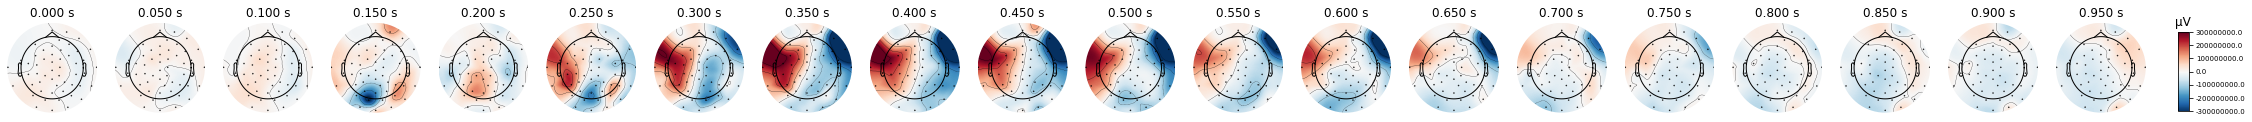

In [246]:
%matplotlib widget
val = 3e8
times = np.arange(0,1,0.05)
evoked_z.plot_topomap(times, average=0.02, vmin=-val, vmax=val)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

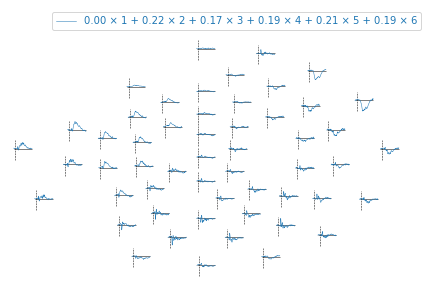

In [249]:
%matplotlib widget
evoked_z.plot_topo()

In [257]:
# OSL preproc
outdir = os.path.join('rich_data', 'opm_rich', 'oslpy')

config_text = """
meta:
  event_codes:
    words/hungry: 2
    words/tired: 3
    words/thirsty: 4
    words/toilet: 5
    words/pain: 6
preproc:
  - filter:         {l_freq: 1, h_freq: 40}
  - notch_filter:   {freqs: 50 100}
  - bad_channels:   {picks: 'eeg'}
  - bad_segments:   {segment_len: 800, picks: 'eeg'}
  - ica_raw:        {picks: 'eeg', n_components: 50}
"""


In [271]:
raw.save('rich_data/opm_rich/Task/raw.fif', overwrite=True)

In [272]:
config = yaml.load(config_text, Loader=yaml.FullLoader)
dataset = osl.preprocessing.run_proc_chain('rich_data/opm_rich/Task/raw.fif', config, outdir=outdir, overwrite=True)

raw : OSL osl_logger: handler 'console' level set to 'INFO'
raw : logging to file: rich_data/opm_rich/oslpy/raw_preproc_raw.log
raw : 2022-09-09 17:20:53 : Starting OSL Processing
raw : input : rich_data/opm_rich/Task/raw.fif
raw : IMPORTING: rich_data/opm_rich/Task/raw.fif
raw : Detected fif file format, using: mne.io.read_raw_fif
raw : MNE Stage - raw.filter
raw : userargs: {'l_freq': 1, 'h_freq': 40}
raw : MNE Stage - raw.notch_filter
raw : userargs: {'freqs': '50 100'}
raw : OSL Stage - raw : detect_badchannels
raw : userargs: {'picks': 'eeg'}
raw : Modality eeg - 13/159 channels rejected     (8.176101%)
['K8 [Z]', 'KB [Z]', 'KC [Z]', 'LC [Z]', 'LF [Y]', 'LF [Z]', 'LE [Y]', 'LE [Z]', 'LM [Y]', 'LM [Z]', 'LN [X]', 'LN [Y]', 'LN [Z]']
raw : OSL Stage - raw : detect_badsegments
raw : userargs: {'segment_len': 800, 'picks': 'eeg'}
raw : Found 47 bad segments
raw : Modality picks - 69.899167/1933.9 seconds rejected     (3.614415%)
raw : MNE Stage - mne.preprocessing.ICA
raw : userargs: 

In [284]:
raw_proc = dataset['raw']
raw_proc = raw_proc.drop_channels(raw_proc.info['bads'])

In [286]:
x_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[X]' in c]
y_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Y]' in c]
z_inds = [i for i, c in enumerate(raw_proc.ch_names) if '[Z]' in c]

In [273]:
ica = dataset['ica']

In [275]:
comps = ica.get_components()

In [276]:
comps.shape

(146, 50)

In [294]:
ica_sources = ica.get_sources(raw_proc).get_data()

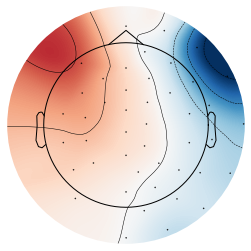

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [380]:
%matplotlib inline
index = 6

ch_names = [c for c in raw_proc.ch_names if '[Z]' in c]
info_z = raw_proc.copy().pick_channels(ch_names).info
mne.viz.plot_topomap(comps[z_inds, index], info_z)

%matplotlib widget
plt.plot(ica_sources[index][40000:80000], linewidth=0.5)

In [381]:
ica.exclude = [6, 12, 15]

In [382]:
raw_proc = ica.apply(raw_proc)

In [383]:
# save data
raw_proc.save('rich_data/opm_rich/Task/raw_preproc.fif')

/var/folders/nv/wjmf18wd5_j38vg9v0cthl5h0000gn/T/ipykernel_27766/1391274201.py:2: RuntimeWarning: This filename (/Users/ricsi/Documents/GitHub/MEG-transfer-decoding/scripts/rich_data/opm_rich/Task/raw_preproc.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_proc.save('rich_data/opm_rich/Task/raw_preproc.fif')
